In [1]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

# GPU 사용 가능 여부 확인
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# GPU 메모리 증가 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Get GPU memory info using nvidia-smi
            import subprocess
            def get_gpu_memory():
                command = "nvidia-smi --query-gpu=memory.total --format=csv,noheader,nounits"
                memory_total = subprocess.check_output(command.split()).decode('ascii').strip().split('\n')[0]
                return int(memory_total)
            
            total_memory = get_gpu_memory()
            print(f'GPU {gpu.name} memory limit: {total_memory/1024:.2f} GB')
    except (RuntimeError, FileNotFoundError, subprocess.CalledProcessError) as e:
        print(f"Error getting GPU info: {e}")

# GPU 장치 설정
try:
    print('Default GPU: {}'.format(tf.test.gpu_device_name()))
except Exception as e:
    print(f"Error while finding GPUs: {e}")
    print(f"Available GPUs: {gpus[0].name}")


2025-01-08 14:52:54.942714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 14:52:54.971307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736315574.992629  377799 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736315574.999333  377799 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 14:52:55.035884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU /physical_device:GPU:0 memory limit: 12.00 GB
Default GPU: /device:GPU:0


I0000 00:00:1736315579.073456  377799 gpu_device.cc:2022] Created device /device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path('./dogs-vs-cats/train')
new_base_dir = pathlib.Path('./dogs-vs-cats_small')

def make_subset(subset_name, start_index, end_index):
    for category in ("dog", "cat"):
        dir = new_base_dir / subset_name / category
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
        
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname,
                            dst = dir / fname)

make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)

In [3]:
convnet_inputs = keras.Input(shape=(180, 180, 3))

convnet_layer = layers.Rescaling(1.0/255)(convnet_inputs)
convnet_layer = layers.Conv2D(filters = 32, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 64, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 128, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.Flatten()(convnet_layer)

convnet_outputs = layers.Dense(1, activation='sigmoid')(convnet_layer)
convnet_model = keras.Model(inputs = convnet_inputs, outputs = convnet_outputs, name="convnet_from_scratch")

convnet_model.summary()

convnet_model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

I0000 00:00:1736315580.363490  377799 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "convnet_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory = new_base_dir / 'train',
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    directory = new_base_dir / 'validation',
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    directory = new_base_dir / 'test',
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [6]:
def checkpoint_save(filepath):
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only = True,
        monitor = 'val_loss',
    )
    return checkpoint

In [7]:
history = convnet_model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = checkpoint_save("convnet_from_scratch.keras")
)

Epoch 1/30


I0000 00:00:1736315582.803961  377940 service.cc:148] XLA service 0x7fea340097e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736315582.804160  377940 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-08 14:53:02.824642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736315582.945193  377940 cuda_dnn.cc:529] Loaded cuDNN version 90600


11/63 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4902 - loss: 0.8825

I0000 00:00:1736315585.475237  377940 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.4934 - loss: 0.7546 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5151 - loss: 0.6945 - val_accuracy: 0.5050 - val_loss: 0.6919
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5296 - loss: 0.6914 - val_accuracy: 0.6490 - val_loss: 0.6730
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5969 - loss: 0.6707 - val_accuracy: 0.6260 - val_loss: 0.6515
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6423 - loss: 0.6340 - val_accuracy: 0.6490 - val_loss: 0.6183
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6587 - loss: 0.6151 - val_accuracy: 0.6560 - val_loss: 0.6088
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ -0s -3684us/step - accuracy: 0.7163 - loss: 0.5740 - val_accuracy: 0.6350 - val_loss: 0.6230
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7358 - loss: 0.5393 - val_accuracy: 0.6390 - val_loss

In [8]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.plot(accuracy, label='accuracy')
    ax1.plot(val_accuracy, label='val_accuracy')
    ax1.legend()

    ax2.plot(loss, label='loss')
    ax2.plot(val_loss, label='val_loss')
    ax2.legend()

    plt.legend()
    plt.show()

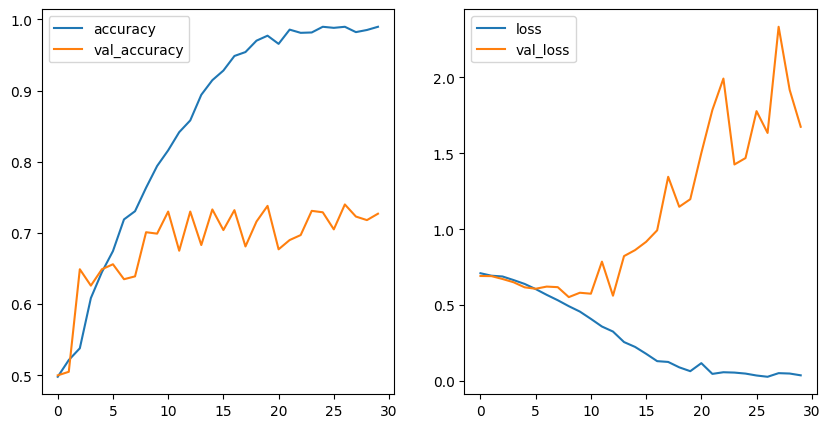

In [9]:
plot_history(history)

In [10]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7099 - loss: 0.5641
Test accuracy: 0.710


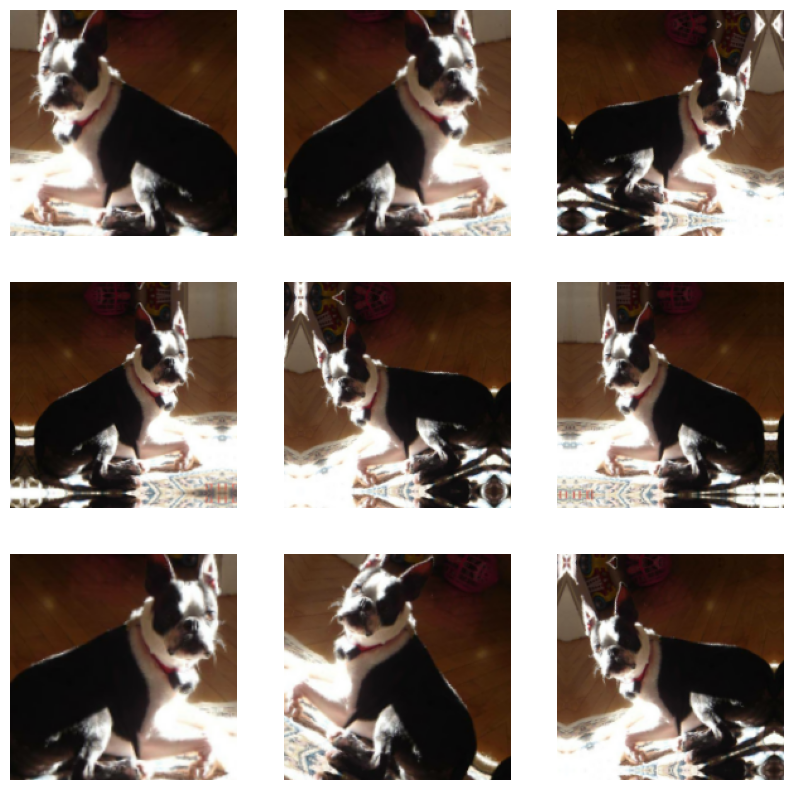

2025-01-08 14:53:42.760883: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')
    plt.show()

In [13]:
convnet_inputs = keras.Input(shape=(180, 180, 3))

convnet_layer = data_augmentation(convnet_inputs)
convnet_layer = layers.Rescaling(1.0/255)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 32, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 64, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 128, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.MaxPooling2D(pool_size = 2)(convnet_layer)
convnet_layer = layers.Conv2D(filters = 256, kernel_size = 3, activation='relu')(convnet_layer)
convnet_layer = layers.Flatten()(convnet_layer)
convnet_layer = layers.Dropout(0.5)(convnet_layer)
convnet_outputs = layers.Dense(1, activation='sigmoid')(convnet_layer)
convnet_model = keras.Model(inputs = convnet_inputs, outputs = convnet_outputs, name="convnet_from_scratch_augmented")

convnet_model.summary()

convnet_model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

Model: "convnet_from_scratch_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
convnet_aug_history = convnet_model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = checkpoint_save("convnet_from_scratch_augmented.keras")
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6026 - loss: 0.6863 - val_accuracy: 0.6010 - val_loss: 0.6508
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6286 - loss: 0.6624 - val_accuracy: 0.6560 - val_loss: 0.6248
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6405 - loss: 0.6458 - val_accuracy: 0.6070 - val_loss: 0.6803
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6441 - loss: 0.6371 - val_accuracy: 0.6540 - val_loss: 0.5984
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6720 - loss: 0.5981 - val_accuracy: 0.6840 - val_loss: 0.5803
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7092 - loss: 0.5782 - val_accuracy: 0.6680 - val_loss: 0.6042
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6763 - loss: 0.5924 - val_accuracy: 0.6820 - val_loss: 0.5905
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6959 - loss: 0.6201 - val_accuracy: 0.

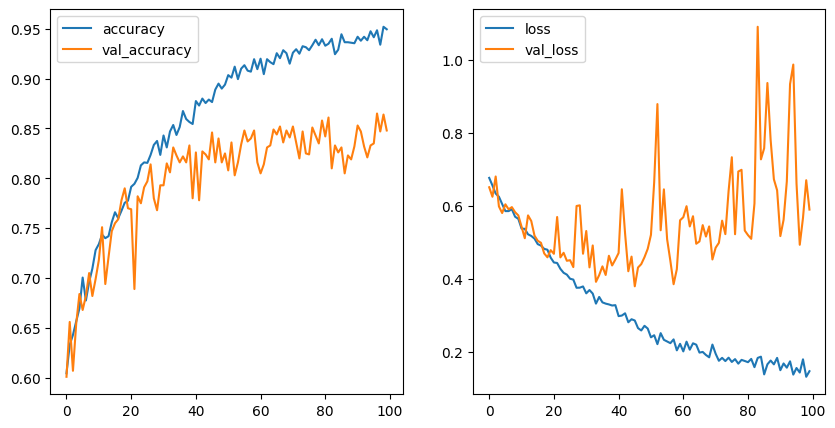

In [16]:
plot_history(convnet_aug_history)

In [17]:
convnet_aug_best = keras.models.load_model("convnet_from_scratch_augmented.keras")
convnet_aug_best_loss, convnet_aug_best_acc = convnet_aug_best.evaluate(test_dataset)
print(f"Test accuracy: {convnet_aug_best_acc:.3f}")

convnet_aug_best.summary()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8281 - loss: 0.4193
Test accuracy: 0.827


Model: "convnet_from_scratch_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

In [18]:
vgg16_base = keras.applications.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (180, 180, 3)
)

vgg16_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def get_feature_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = vgg16_base(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_feature_and_labels(train_dataset)
val_features, val_labels = get_feature_and_labels(validation_dataset)
test_features, test_labels = get_feature_and_labels(test_dataset)

train_features.shape, val_features.shape, test_features.shape

2025-01-08 14:57:00.320692: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-08 14:57:04.283916: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


((2000, 5, 5, 512), (1000, 5, 5, 512), (2000, 5, 5, 512))

In [20]:
vgg16_top_input = keras.Input(shape=(5, 5, 512))

vgg16_top_layer = layers.Flatten()(vgg16_top_input)
vgg16_top_layer = layers.Dense(256, activation='relu')(vgg16_top_layer)
vgg16_top_layer = layers.Dropout(0.5)(vgg16_top_layer)

vgg16_top_output = layers.Dense(1, activation='sigmoid')(vgg16_top_layer)
vgg16_top = keras.Model(inputs = vgg16_top_input, outputs = vgg16_top_output, name="vgg16_top")

vgg16_top.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [21]:
vgg16_top_history = vgg16_top.fit(
    train_features, train_labels,
    epochs = 20,
    validation_data = (val_features, val_labels),
    callbacks = checkpoint_save("vgg16_top.keras")
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8517 - loss: 15.2821 - val_accuracy: 0.9600 - val_loss: 1.2321
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9729 - loss: 0.8879 - val_accuracy: 0.9760 - val_loss: 0.9841
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9785 - loss: 0.5959 - val_accuracy: 0.9720 - val_loss: 0.8241
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9881 - loss: 0.2788 - val_accuracy: 0.9690 - val_loss: 1.1553
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9896 - loss: 0.3360 - val_accuracy: 0.9800 - val_loss: 0.4717
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 0.3301 - val_accuracy: 0.9800 - val_loss: 0.6612
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.0667 - val_accuracy: 0.9800 - val_loss: 0.7179
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.2055 - val_accuracy: 0.9780 - val_los

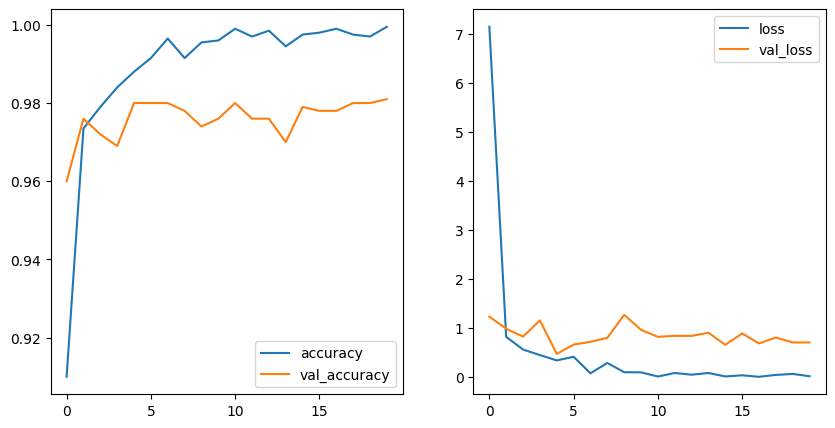

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9795 - loss: 0.8112 
Test accuracy: 0.972


Model: "vgg16_top"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,554,628 (25.00 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,277,315 (12.50 MB)

In [34]:
plot_history(vgg16_top_history)

vgg16_top_best = keras.models.load_model("vgg16_top.keras")
vgg16_loss, vgg16_acc = vgg16_top_best.evaluate(test_features, test_labels)
print(f"Test accuracy: {vgg16_acc:.3f}")

vgg16_top_best.summary()

In [26]:
vgg16_base_freeze = keras.applications.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (180, 180, 3)
)

vgg16_base_freeze.trainable = False
vgg16_base_freeze.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
vgg16_freeze_input = keras.Input(shape=(180, 180, 3))

vgg16_freeze_layers = data_augmentation(vgg16_freeze_input)
vgg16_freeze_layers = keras.applications.vgg16.preprocess_input(vgg16_freeze_layers)
vgg16_freeze_layers = vgg16_base_freeze(vgg16_freeze_layers)
vgg16_freeze_layers = layers.Flatten()(vgg16_freeze_layers)
vgg16_freeze_layers = layers.Dense(256, activation='relu')(vgg16_freeze_layers)
vgg16_freeze_layers = layers.Dropout(0.5)(vgg16_freeze_layers)

vgg16_freeze_output = layers.Dense(1, activation='sigmoid')(vgg16_freeze_layers)
vgg16_freeze_model = keras.Model(inputs = vgg16_freeze_input, outputs = vgg16_freeze_output, name="vgg16_freeze")
vgg16_freeze_model.compile(optimizer='rmsprop',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

In [29]:
vgg16_freeze_history = vgg16_freeze_model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = checkpoint_save("vgg16_freeze.keras")
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9850 - loss: 0.0864 - val_accuracy: 0.9790 - val_loss: 0.2075
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9872 - loss: 0.0813 - val_accuracy: 0.9790 - val_loss: 0.2321
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9809 - loss: 0.2062 - val_accuracy: 0.9830 - val_loss: 0.1673
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9867 - loss: 0.0979 - val_accuracy: 0.9830 - val_loss: 0.2320
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9903 - loss: 0.0691 - val_accuracy: 0.9830 - val_loss: 0.1723
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9863 - loss: 0.1138 - val_accuracy: 0.9840 - val_loss: 0.2324
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9836 - loss: 0.1410 - val_accuracy: 0.9770 - val_loss: 0.2858
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9872 - loss: 0.0715 - val_accuracy: 0.9820 - v

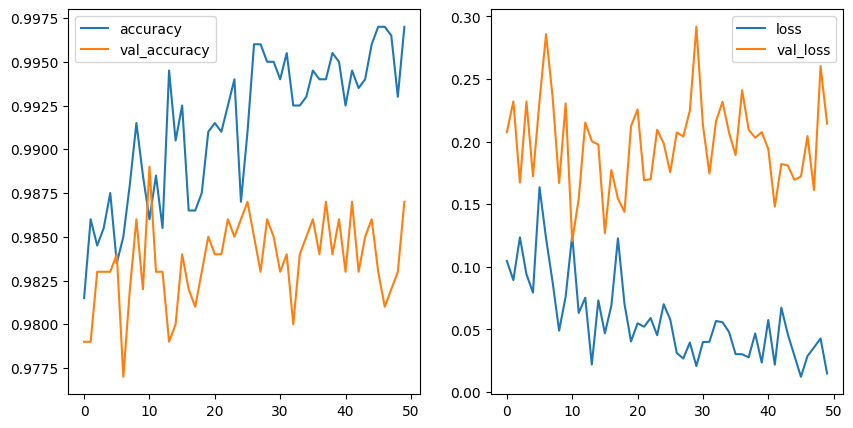

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9856 - loss: 0.1960
Test accuracy: 0.981


Model: "vgg16_freeze"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_7[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,269,316 (81.14 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,277,315 (12.50 MB)

In [33]:
plot_history(vgg16_freeze_history)

vgg16_freeze_best = keras.models.load_model("vgg16_freeze.keras")
vgg16_freeze_loss, vgg16_freeze_acc = vgg16_freeze_best.evaluate(test_dataset)
print(f"Test accuracy: {vgg16_freeze_acc:.3f}")

vgg16_freeze_best.summary()

In [35]:
# Unfreezing later layers for fine-tuning
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

vgg16_freeze_model.compile(optimizer='rmsprop',
                            loss='binary_crossentropy',
                            metrics=['accuracy']
)

vgg16_finetune_history = vgg16_freeze_model.fit(
                        train_dataset,
                        epochs = 50,
                        validation_data = validation_dataset,
                        callbacks = checkpoint_save("vgg16_finetune.keras")
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9949 - loss: 0.0235 - val_accuracy: 0.9850 - val_loss: 0.1980
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9989 - loss: 0.0064 - val_accuracy: 0.9860 - val_loss: 0.2142
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9980 - loss: 0.0195 - val_accuracy: 0.9840 - val_loss: 0.2436
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9830 - val_loss: 0.2261
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9931 - loss: 0.0572 - val_accuracy: 0.9850 - val_loss: 0.2980
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9948 - loss: 0.0813 - val_accuracy: 0.9880 - val_loss: 0.2523
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9930 - loss: 0.0970 - val_accuracy: 0.9860 - val_loss: 0.2319
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9946 - loss: 0.0399 - val_accuracy: 0.9840 - v

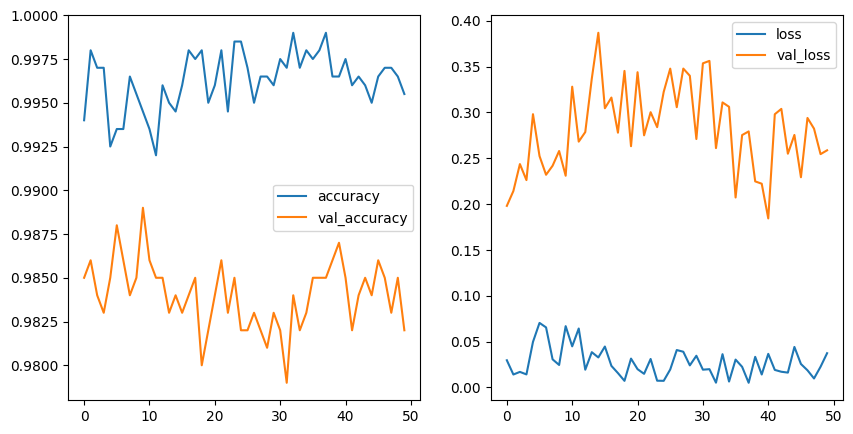

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9801 - loss: 0.3646
Test accuracy: 0.979


Model: "vgg16_freeze"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_7[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,269,316 (81.14 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,277,315 (12.50 MB)

In [36]:
plot_history(vgg16_finetune_history)

vgg16_finetune_best = keras.models.load_model("vgg16_finetune.keras")
vgg16_finetune_loss, vgg16_finetune_acc = vgg16_finetune_best.evaluate(test_dataset)
print(f"Test accuracy: {vgg16_finetune_acc:.3f}")

vgg16_finetune_best.summary()